# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [1]:
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

import numpy as np
import sympy
import cv2
import os

from PIL import Image
import pickle

# Provided functions

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    print('Set at least {} lines to compute vanishing point'.format(min_lines))
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least {} lines, you have {} now'.format(min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(ax, im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10
    
    ax.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    ax.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    ax.set_xlim([bx1, bx2])
    ax.set_ylim([by2, by1])

# Your implementation

In [4]:
def get_vanishing_point(n, lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    vpt = []
    for i in range(n):
        for j in range(i+1, n):
            vpt.append(np.cross(lines[:,i], lines[:,j]))
            
    return np.mean(np.array(vpt), axis=0)

In [23]:
def get_horizon_line(vpts):
    """
    Calculates the ground horizon line.
    """
    line = np.cross(vpts[:,0], vpts[:,1])
    return line/np.linalg.norm(line[:1])

In [6]:
def plot_horizon_line(ax, im, horizon_line):
    """
    Plots the horizon line.
    """
    x = np.linspace(0, im.shape[1])
    y = (-horizon_line[2]-horizon_line[0]*x)/horizon_line[1]
    
    ax.imshow(im)
    ax.plot(x, y, 'g')
    ax.set_xlim([0, im.shape[1]])
    ax.set_ylim([im.shape[0], 0])

In [7]:
def get_camera_parameters(n, vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    f, px, py = sympy.symbols('f, px, py')
    K = sympy.Matrix([[f, 0, px], [0, f, py], [0, 0, 1]])
    
    v, e = [], []
    for i in range(n):
        v.append(vpts[:, i].reshape((-1, 1)))
        
    for i in range(n):
        for j in range(i+1, n):
            e.append(v[i].T*K.inv().T*K.inv()*v[j])
    
    f, px, py = sympy.solve(e, [f, px, py])[0]
    return abs(f), px, py, np.array([[f, 0, px], [0, f, py], [0, 0, 1]], dtype=np.float32)

In [8]:
def get_rotation_matrix(n, vpts, K):
    """
    Computes the rotation matrix using the camera parameters.
    """
    K = np.linalg.pinv(K)
    
    R = []
    for i in range(n):
        ri = K.dot(vpts[:, 0].reshape((-1, 1)))
        R.append(ri/np.linalg.norm(ri))
    
    return np.hstack(R)

In [9]:
def get_homography():
    """
    Compute homography for transforming the image into fronto-parallel 
    views along the different axes.
    """
    # <YOUR CODE>
    pass

In [10]:
def get_rotation_matrix_rectification():
    """
    Compute the rotation matrix that will be used to compute the 
    homography for rectification.
    """
    # <YOUR CODE>
    pass

# Main function

In [11]:
im = np.asarray(Image.open('./data/Q3/eceb.png'))

# Also loads the vanishing line data if it exists in data.pickle file. 
# data.pickle is written using snippet in the next cell.
if os.path.exists('data.pickle'):
    with open('data.pickle', 'rb') as f:
        all_n, all_lines, all_centers = pickle.load(f, encoding='latin1')
    num_vpts = 3

In [12]:
# Click and save the line data for vanishing points. This snippet 
# opens up an interface for selecting points and writes them to 
# data.pickle file. The file is over-written.

# num_vpts = 3
# all_n, all_lines, all_centers = [], [], []

# for i in range(num_vpts):
#     print('Getting vanishing point {}'.format(i))
#     fig = plt.figure(); ax = fig.gca()
    
#     # Get at least three lines from user input
#     n_i, lines_i, centers_i = get_input_lines(im)
#     all_n.append(n_i)
#     all_lines.append(lines_i)
#     all_centers.append(centers_i)

# with open('data.pickle', 'wb') as f:
#     pickle.dump([all_n, all_lines, all_centers], f)

[-68800809.05893475 -22378343.37308404   -101420.76653107]
[2.07585221e+08 5.94581244e+06 3.40002796e+04]
[-1.70544872e+07 -5.96742180e+07 -1.69585507e+04]


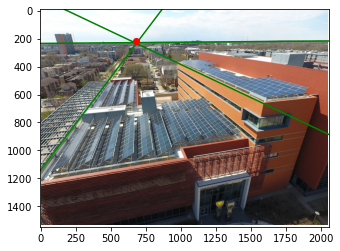

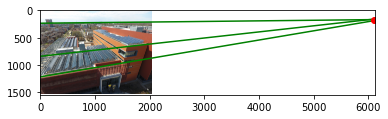

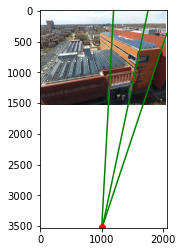

In [14]:
# Part (a)
# Computing vanishing points for each of the directions
vpts = np.zeros((3, num_vpts))

for i in range(num_vpts):
    fig = plt.figure(); ax = fig.gca()
    
    # <YOUR CODE> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(all_n[i], all_lines[i])
    print(vpts[:, i])
    
    # Plot the lines and the vanishing point
    plot_lines_and_vp(ax, im, all_lines[i], vpts[:, i])
    fig.savefig('Q3_vp{:d}.pdf'.format(i), bbox_inches='tight')

Line ax+by+c=0 with parameter a = -1.000000, b = -118.563596, c = 26839.253582


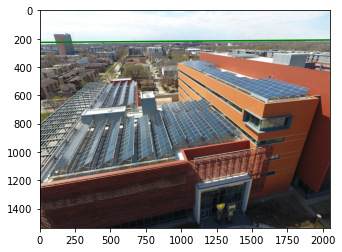

In [24]:
# Part (b) Computing and plotting the horizon
# <YOUR CODE> Get the ground horizon line
horizon_line = get_horizon_line(vpts)
print("Line ax+by+c=0 with parameter a = %f, b = %f, c = %f" % (horizon_line[0], horizon_line[1], horizon_line[2]))

# <YOUR CODE> Plot the ground horizon line
fig = plt.figure(); ax = fig.gca()
plot_horizon_line(ax, im, horizon_line)
fig.savefig('Q3_horizon.pdf', bbox_inches='tight')

In [25]:
# Part (c) Computing Camera Parameters
# <YOUR CODE> Solve for the camera parameters (f, u, v)
f, u, v, K = get_camera_parameters(num_vpts, vpts)
print(u, v, f, K)

981.741524764882 683.309387771954 1148.53760552980 [[-1.1485376e+03  0.0000000e+00  9.8174152e+02]
 [ 0.0000000e+00 -1.1485376e+03  6.8330939e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [26]:
# Part (d) Computing Rotation Matrices
# <YOUR CODE> Solve for the rotation matrix
R = get_rotation_matrix(num_vpts, vpts, K)
print(R)

[[-0.23796751 -0.23796751 -0.23796751]
 [-0.36291557 -0.36291557 -0.36291557]
 [-0.90092384 -0.90092384 -0.90092384]]


In [ ]:
# Part (e) Generating fronto-parallel warps. Compute the 
# appropriate rotation to transform the world coordinates
# such that the axis of projection becomes the world
# X, Y and Z axes respectively. Use this rotation to estimate
# a homography that will be used to compute the output view.
# Apply the homography to generate the 3 fronto-parallel
# views and save them.

Rt = get_rotation_matrix_rectification()
H = get_homography()
    
fig = plt.figure(); ax = fig.gca()
# cv2.imwrite('Q3_im{:d}.jpg'.format(i), im_dst,
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])